In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
#Import the necessary libraries

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import cross_validate
import math

In [3]:
#Create dataframe by reading given input csv file using pandas

df = pd.read_csv("/Users/Rattlehead/Downloads/GreatLakes/ratings_Electronics.csv")

In [4]:
#Lets check how the data looks like currently

df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
#Lets give meaningful names to the columns

df.columns = ["userId", "productId", "rating", "timestamp"]

In [6]:
#Display shape of dataframe

df.shape

(7824481, 4)

In [7]:
#thats a lot of data, lets check the data types

df.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

In [8]:
# 5 point summary of numerical attributes can be seen using describe

df.describe()

,rating,timestamp
count,7.824481e+06,7.824481e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [9]:
#We just have one numerical column which is Rating and it looks like majority of users have given 5.0 rating

In [10]:
#Check for missing values

df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [11]:
#Check for duplicate rows

dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


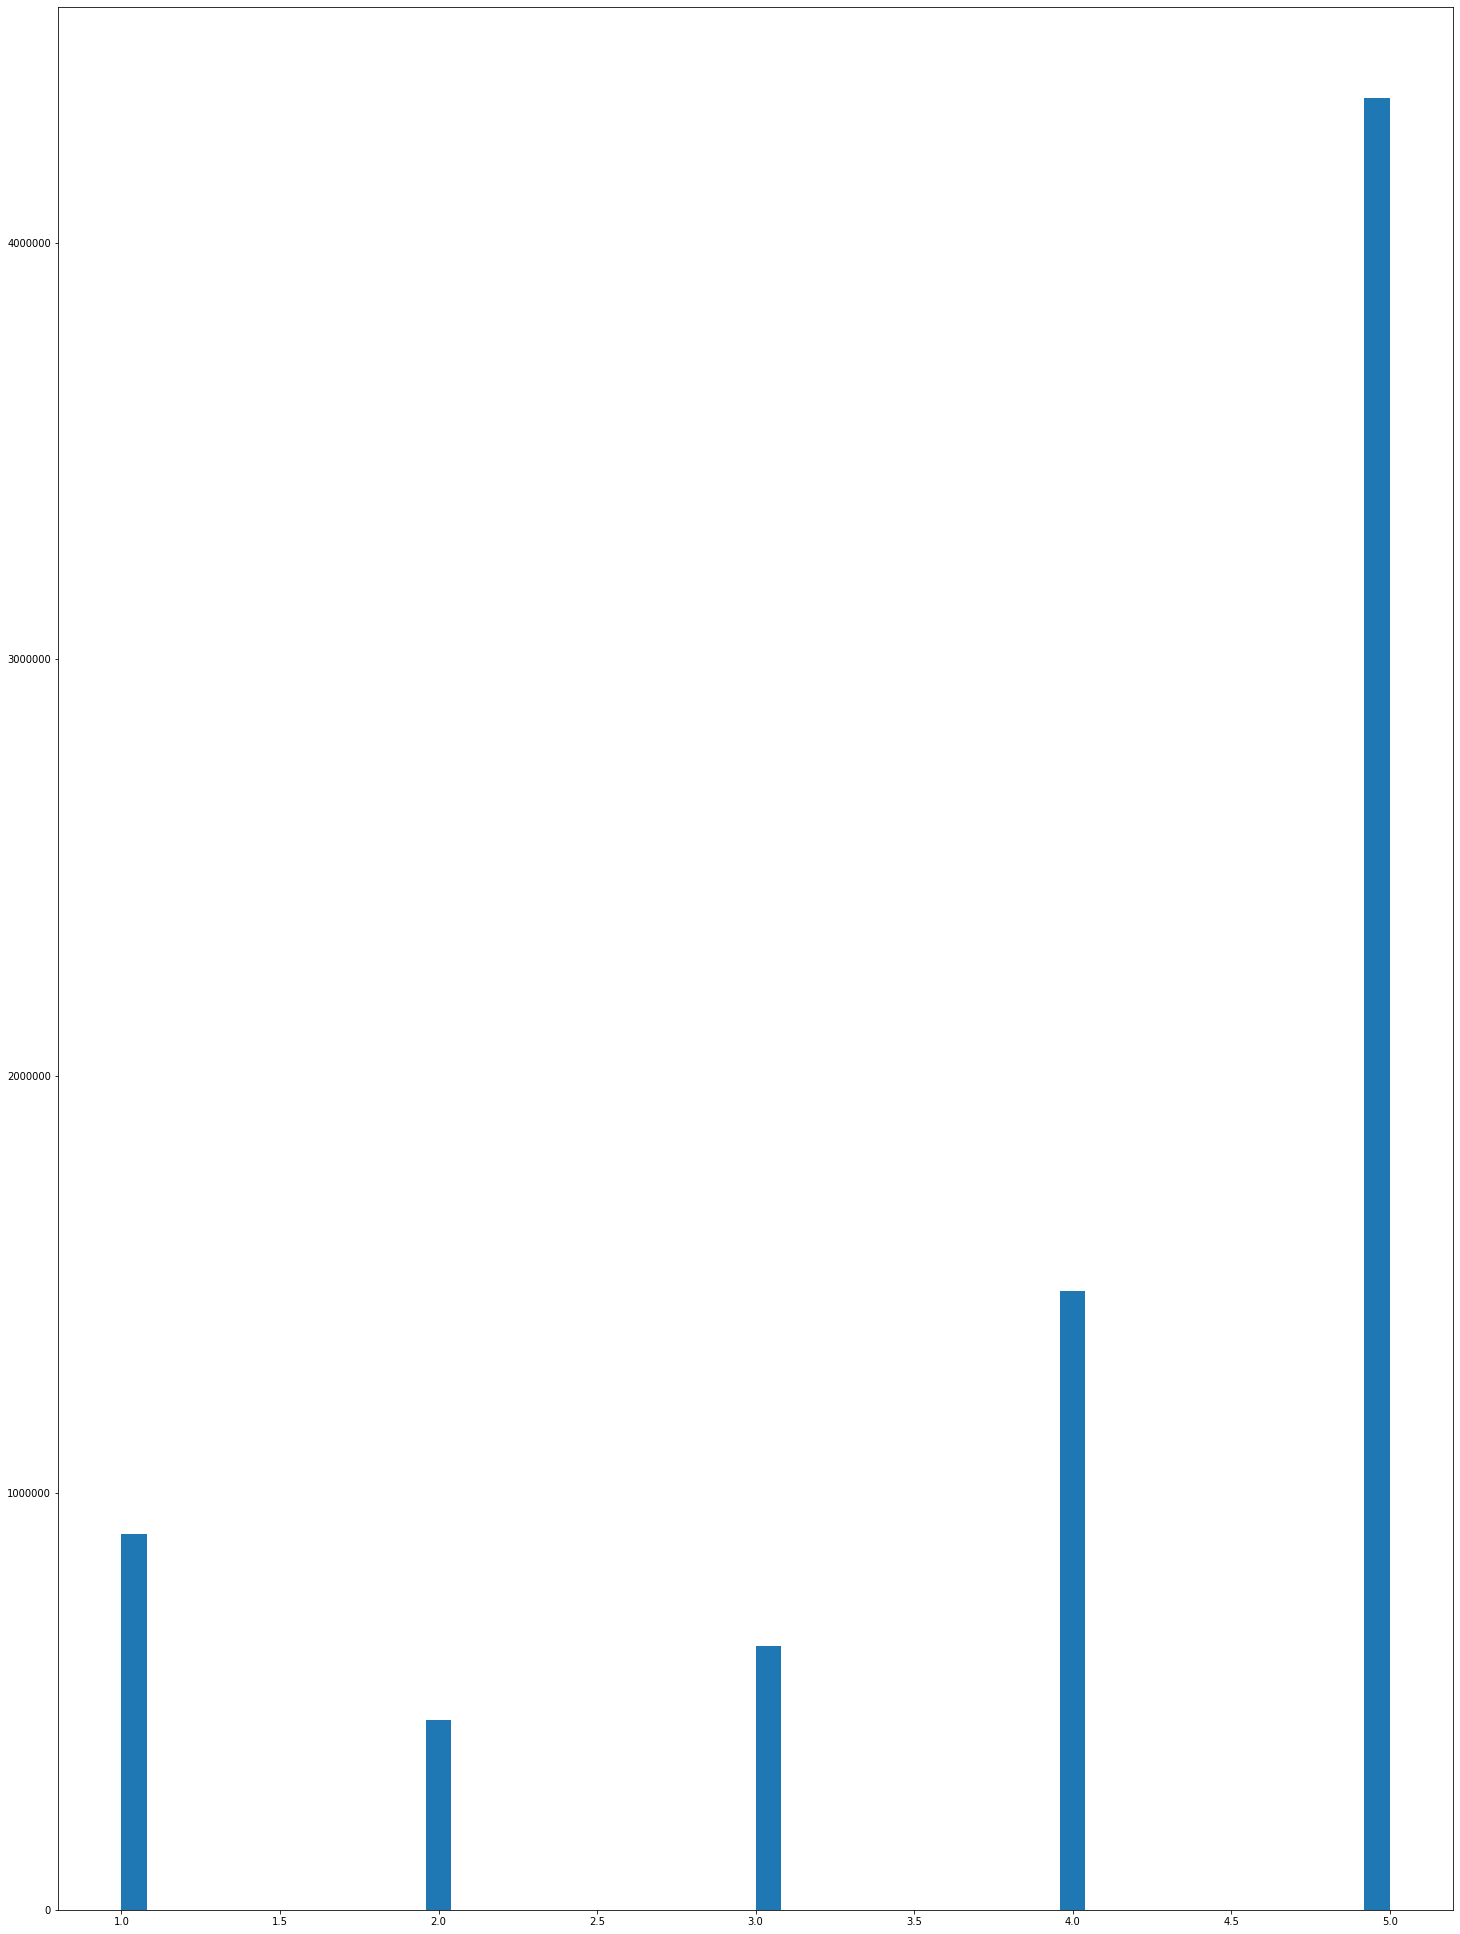

In [12]:
#Lets display the histogram for rating

df["rating"].hist(stacked=False, bins=50, figsize=(25,35), grid=False)

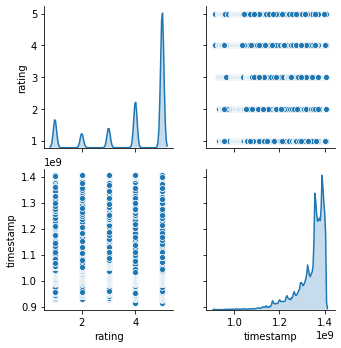

In [13]:
#Lets display the pair plot

sns.pairplot(df, diag_kind='kde')

In [14]:
#From Histogram and pair plot we can see that we have more users who have given 4 and considerably high numbers of 
#users who have given 5 as rating

In [15]:
#Get the data only for users who have given 50+ ratings

dfUser = df.groupby(['userId'])

In [16]:
dfUser = dfUser.filter(lambda x: len(x) >= 50)

In [17]:
#Lets verify the rows if they have reduced

dfUser.shape

(125871, 4)

In [18]:
#Split the data into train and test data

dfUser_Train, dfUser_Test = train_test_split(dfUser, test_size=0.3, random_state=1)

In [19]:
#Top 5 products on the basis of mean of ratings given by the user

dfUser_Train.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00LKG1MC8    5.0
B002P5DNY8    5.0
B002P3KMVC    5.0
B002P3KMXA    5.0
B002P3KMXU    5.0
Name: rating, dtype: float64

In [20]:
#Top 5 products on the basis of count of ratings given by the user

dfUser_Train.groupby('productId')['rating'].count().sort_values(ascending=False).head()  

productId
B0088CJT4U    155
B003ES5ZUU    124
B000N99BBC    122
B007WTAJTO    112
B00829TIEK    100
Name: rating, dtype: int64

In [21]:
#Get the dataframe with mean ratings

dfUser_Train_mean = pd.DataFrame(dfUser_Train.groupby('productId')['rating'].mean()) 

#Lets add rating_counts column so that we can clearly see the number of ratings provided for a product
#and avoid the bias of products which were highly rated but but given rating less number of times

dfUser_Train_mean['rating_counts'] = pd.DataFrame(dfUser_Train.groupby('productId')['rating'].count())  
dfUser_Train_mean.head()

,rating,rating_counts
productId,,
0594451647,5.0,1
0970407998,2.5,2
0972683275,5.0,2
1400501466,3.0,2
1400501520,5.0,1


In [22]:
#So the top recommended products should be highest rated and with highest rating_counts

dfUser_Train_mean_sort = dfUser_Train_mean.sort_values(['rating', 'rating_counts'], ascending = [0,0])

dfUser_Train_mean_sort.head()

,rating,rating_counts
productId,,
B0052SCU8U,5.0,33
B0046TJG1U,5.0,17
B003MTTJOY,5.0,15
B000F7QRTG,5.0,14
B000IJY8DS,5.0,14


In [23]:
#Collabrative Filtering

#Drop timestamp cloumn as its not required for steps ahead
dfUserC = dfUser.drop(['timestamp'], axis = 1) 

# A reader is  needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, product id and ratings (in that order).
dataUserC = Dataset.load_from_df(dfUserC, reader)

#Split the data into training and test data
trainset, testset = surprise_train_test_split(dataUserC, test_size=0.3)
 
#Lets build the model with KNNWithMeans algorithm
model = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [24]:
# run the trained model against the testset
test_pred = model.test(testset)
test_pred

[Prediction(uid='A2HKUM9OEBQKDW', iid='B00GOUBT6E', r_ui=5.0, est=4.235294117647059, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2MR696ZU17F12', iid='B0009JR42E', r_ui=4.0, est=3.6315789473684212, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3D01HLSUFEZQY', iid='B00085ESDC', r_ui=5.0, est=4.259803198311182, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3VI2VETB90ZG5', iid='B003XREDVE', r_ui=4.0, est=4.259803198311182, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AG5WSXI52FPKH', iid='B002RM08RE', r_ui=2.0, est=4.195121951219512, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2WB7LZ595CR50', iid='B0017HBO8W', r_ui=4.0, est=3.7009345794392523, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A37CEYB95LK6R6', iid='B00009XVCZ', r_ui=4.0, est=4.698467692855395, details={'actual_k': 2, 'was_impossible': False}

In [25]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0549


1.0548577074681111

In [26]:
# Run 5-fold cross-validation and print results
cross_validate(model, dataUserC, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0590  1.0575  1.0587  1.0545  1.0569  1.0573  0.0016  
MAE (testset)     0.7752  0.7730  0.7778  0.7764  0.7742  0.7753  0.0017  
Fit time          0.77    0.80    0.82    0.81    0.81    0.80    0.02    
Test time         0.53    0.51    0.51    0.50    0.

{'test_rmse': array([1.05901662, 1.05754638, 1.05865168, 1.05446273, 1.05687288]),
 'test_mae': array([0.77520314, 0.77299679, 0.77775376, 0.77644638, 0.77417863]),
 'fit_time': (0.7668731212615967,
  0.8016228675842285,
  0.8236019611358643,
  0.8093149662017822,
  0.8051180839538574),
 'test_time': (0.5339469909667969,
  0.5095400810241699,
  0.5108633041381836,
  0.4984560012817383,
  0.5181641578674316)}

In [27]:
#Lets calcualte RMSE for Model 1

#productId appears to be index value of dfUser_Train_mean_sort dataframe,
#we need to be able to add those values as column values
dfUser_Train_mean_sort['productId'] = dfUser_Train_mean_sort.index

#RMSE
count = 0
sumOfSquaredError = 0
for ind in dfUser_Test.index:
    testProductId = dfUser_Test['productId'][ind]
    if testProductId in dfUser_Train_mean_sort.values: 
        predictedRating = dfUser_Train_mean_sort.loc[testProductId, :].rating
        actualRating = dfUser_Test['rating'][ind]
        diff = predictedRating - actualRating
        sumOfSquaredError = sumOfSquaredError + diff**2
        count = count + 1

rmse = math.sqrt(sumOfSquaredError)/count
print(count)
print(rmse)

26839
0.006704751151013051


In [43]:
#Recommend top 5 new products to a given user

#It should logically come from user-user collaborative filtering

#We can build a function which can loop through trainset for a given user from testset
#I guess surprise.trainset does not have any iterator but with other neighbouring 
#algorithms which does provide iterator for trainset, we can pass the productIds to

#model.predict('given_user_id', 'productId', verbose=True)

#and get the top 5 products with highest rating and which has some value for 'actual_k' and False
#for was_impossible

In [44]:
#One thing to note here for Model 1 is that the outcome of recommendation based on mean sorted ratings
#will be the same for each and every user since it is popularity based and not personalized.
#UserId has not been used at all for popularity based recommendation system which supports the statement
#mentioned above.

#Hence the prediction for a particular product might not be valid at all because there are chances
#that while splitting data randomly into training and test data, that product might fall into just one of the 
#datasets: either train or test
#The count of products in test data for which model was able to predict is supportive of above statement
#as it is less than (0.3 * 125871)

#We observed RMSE for Collaborative filtering model as 1.0558 which is more realistic than what we 
#got for Model 1

#Collaborative Filtering is the most common technique used when it comes to building intelligent recommender systems 
#that can learn to give better recommendations as more information about users is collected.
#As we know, Collaborative filtering is a technique that can filter out items that a user might like on the basis of 
#reactions by similar users.